# <center> <font face = "Corbel" size = "7" color="firebrick"> Dog breeds identification using Neural Networks

<center> <font face = "Corbel light" size = "5" color ="black"> Aina Belloni 5007697

<center> <font face = "Corbel light" size = "5" color ="black">  Giulia Beatrice Crespi 5009457

## <font face = "Corbel light" size = "5"> **Libraries**

In [1]:
%%capture
!pip install torch torchvision d2l

In [2]:
import pandas as pd
import torch
from torch.utils import data
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn as nn
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
d2l.use_svg_display()
%matplotlib inline

#libraries from object detection 
from pathlib import Path
import cv2
import torch
import torchvision.transforms.functional as F
from torchvision.io import read_image
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# <font face = "Corbel light" size = "6" color ="firebrick"> **Dataset Exploration**


<font face = "Corbel"> 

For this project, we chose Stanford Dog Breed dataset which contains images of 120 breeds of dogs from around the world. The dataset contains 20,580 images in total. The dataset has been built using images and annotations from ImageNet for the task of image categorization.

(Source Link for downloading the dataset: http://vision.stanford.edu/aditya86/ImageNetDogs/  )


## <font face = "Corbel light" size = "5" color ="tomato"> **Goal**

<font face = "Corbel">  The goal of our project is to implement the best architecture to classify dogs into their breeds. We will start to look and explore our data and then we will implement with different models.

## <font face = "Corbel light" size = "5" color ="tomato"> **Importing the dataset**

<font face = "Corbel"> We import the dataset from Google Drive where each image folder is considered as one category.

In [ ]:
my_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Advanced Programming/Dati dogs/Images')

<font face = "Corbel"> Our dataset has 20580 images of 120 breeds of dogs.

In [ ]:
len(my_dataset)

20580

In [ ]:
len(my_dataset.classes)

120

<font face = "Corbel"> Since our folders have complex names with numbers and symbols we simplify the names of the classes to be more clear. 

In [ ]:
my_dataset.classes[:5]

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih_Tzu']

In [ ]:
name_classes = []
for element in my_dataset.classes:
  name_classes.append(element.split('-')[1])
my_dataset.classes = name_classes

my_dataset.classes[:5]

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih_Tzu']

## <font face = "Corbel light" size = "5" color ="tomato"> **Images per category** 

<font face = "Corbel"> Since our dataset is a dictionary we had to count the numerosity of the indexes of the classes.

In [ ]:
calculate = False # if you want to do the calculations set True, if we want to upload from file set False

In [ ]:
if calculate:
  name_class = []
  i=0
  for key, value in my_dataset:
    if i%1000 == 0:
      print(i) 
    name_class.append(value)
    i += 1

  from itertools import groupby
  count = [len(list(group)) for key, group in groupby(name_class)]

<font face = "Corbel"> It takes very long time so we choose to save the counts once.

In [ ]:
if calculate:
  textfile = open("/content/drive/MyDrive/Advanced Programming/Dati dogs/count_length.txt", "w")
  for element in count:
    textfile.write(str(element) + "\n")
  textfile.close()

<font face = "Corbel"> Upload the counts and visualize **quantitatively** and **graphically** how many images we have per category.

In [ ]:
if calculate == False:
  count0 = open("/content/drive/MyDrive/Advanced Programming/Dati dogs/count_length.txt", "r")
  count = count0.read().split()
  for i in range(0, len(count)):
      count[i] = int(count[i])

In [ ]:
data = {'Breeds':my_dataset.classes,
        'Number of Images': count}

df = pd.DataFrame(data)
df[:10]

,Breeds,Number of Images
0,Chihuahua,152
1,Japanese_spaniel,185
2,Maltese_dog,252
3,Pekinese,149
4,Shih_Tzu,214
5,Blenheim_spaniel,188
6,papillon,196
7,toy_terrier,172
8,Rhodesian_ridgeback,172
9,Afghan_hound,239


<BarContainer object of 30 artists>

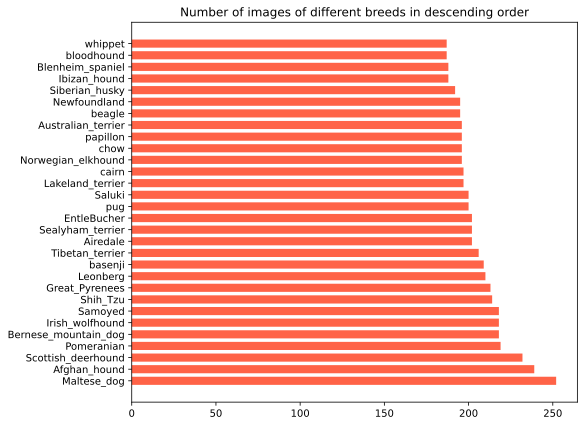

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,7))
plt.title('Number of images of different breeds in descending order')
#sns.barplot(x = 'Number of Images', y = 'Breeds', data = df.sort_values('Number of Images', ascending = False).head(30))
plt.barh('Breeds', 'Number of Images', height=0.7, data=df.sort_values('Number of Images', ascending = False).head(30), color = 'tomato')

## <font face = "Corbel light" size = "5" color ="tomato"> **Boundary boxes**

<font face = "Corbel"> Our data folder contains also information on the boundary boxes, in the *Annoation* folder, so we had to extract information from that and we used the xml.etree.ElementTree package. Then we cropped all the images with the right boundary boxes and we saved all the cropped images in a folder *data* with the same structure as the Images original one.

In [ ]:
from PIL import Image
import xml.etree.ElementTree as ET

In [ ]:
if 'data' not in os.listdir('/content/drive/MyDrive/Advanced Programming/Dati dogs'):
    os.mkdir('/content/drive/MyDrive/Advanced Programming/Dati dogs/data')
    
    for breed in my_dataset.classes:
      os.mkdir('/content/drive/MyDrive/Advanced Programming/Dati dogs/data/' + breed)
    
    for breed in my_dataset.classes:
      for file in os.listdir('/content/drive/MyDrive/Advanced Programming/Dati dogs/Annotation/' + breed):
        img = Image.open('/content/drive/MyDrive/Advanced Programming/Dati dogs/Images/' + breed + '/' + file + '.jpg')
        tree = ET.parse('/content/drive/MyDrive/Advanced Programming/Dati dogs/Annotation/' + breed + '/' + file)
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin,ymin,xmax,ymax))
        img = img.convert('RGB')
        img.save('/content/drive/MyDrive/Advanced Programming/Dati dogs/data_new/' + breed + '/' + file + '.jpg')

<font face = "Corbel"> **Show** an example of 5 images

In [ ]:
list_5 = ['/n02110806-basenji/n02110806_18',
          '/n02107683-Bernese_mountain_dog/n02107683_1003',
          '/n02099601-golden_retriever/n02099601_109',
          '/n02088364-beagle/n02088364_769',
          '/n02102318-cocker_spaniel/n02102318_2073']

breeds = ['Basenji','Bernese mountain dog','Golden retriever','Beagle','Cocker spaniel']

link_images = '/content/drive/MyDrive/Advanced Programming/Dati dogs/Images' 
link_data = '/content/drive/MyDrive/Advanced Programming/Dati dogs/data' 
link_annotation = '/content/drive/MyDrive/Advanced Programming/Dati dogs/Annotation' 

bbox = [] ; images = [] ; img_cropped = []
for file in list_5:
  img = Image.open(link_images + file + '.jpg')
  tree = ET.parse(link_annotation + file)
  xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
  xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
  ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
  ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
  bbox.append([(xmin,ymin), (xmax,ymax)])
  images.append(img)
  img_cropped.append(Image.open(link_data + file + '.jpg'))


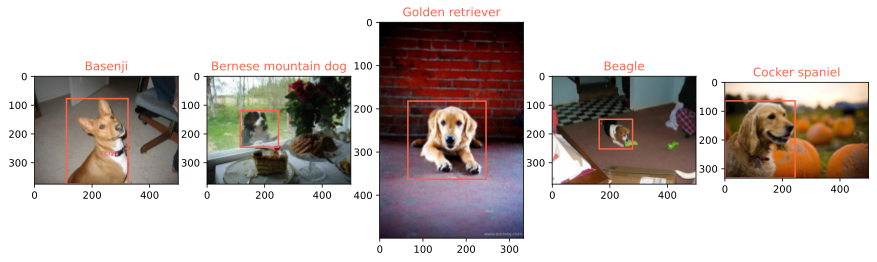

In [ ]:
fig = plt.figure(figsize=(15, 15))
for i in range(5):
  plt.subplot(1,5,i+1)
  #img = plt.imread(data_dir + 'images/Images/' + breed + '/' + dog + '.jpg')
  img=images[i]
  plt.imshow(img)  
  xmin,ymin = bbox[i][0] 
  xmax, ymax = bbox[i][1]
  plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], c='tomato')
  plt.title(breeds[i], c='tomato')

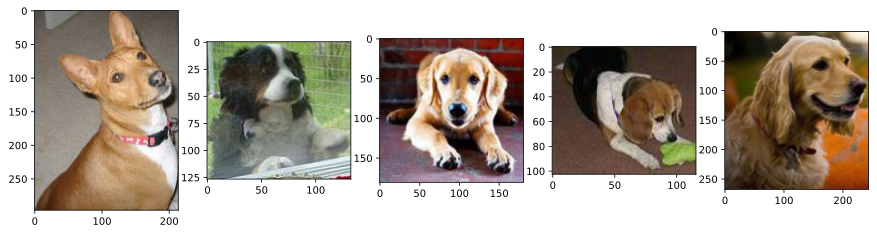

In [ ]:
fig = plt.figure(figsize=(15, 15))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(img_cropped[i]) 

## <font face = "Corbel light" size = "5" color ="tomato"> **Object detection**

<font face = "Corbel"> Useful **libraries** for the object detection

In [ ]:
import torch
import torchvision.transforms.functional as F
from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.models as models
from torchvision.transforms.functional import convert_image_dtype
from torchvision.utils import draw_bounding_boxes

<font face = "Corbel"> We defined a function to show images, with a proper grid.

In [ ]:
def show(imgs, transformed = False):
    if not isinstance(imgs, list):
      imgs = [imgs]
    fig = plt.figure(figsize=(15, 15))
    for i, img in enumerate(imgs):
      plt.subplot(1,len(imgs),i+1)
      img = F.to_pil_image(img)
      plt.imshow(np.asarray(img))

<font face = "Corbel"> Transform images into the right format for the model below, in particular we resized the images to 400x400 and then to a torch Tensor type with 3 channels of colors.

In [ ]:
dogs0 = []; dogs1 = []; dogs= []
i=0
for file in list_5:
  dogs0.append(cv2.imread(link_images + file + '.jpg'))
  dogs1.append(cv2.resize(dogs0[i],dsize=(400,400),interpolation=cv2.INTER_CUBIC))
  dogs.append(torch.from_numpy(cv2.cvtColor(dogs1[i], cv2.COLOR_BGR2RGB)).permute(2,0,1))
  i += 1

print(dogs0[0].shape)
print(dogs1[0].shape)
print(dogs[0].shape)
print(type(dogs[0]))

(375, 500, 3)
(400, 400, 3)
torch.Size([3, 400, 400])
<class 'torch.Tensor'>


<font face = "Corbel"> We tried with a neural network architecture to detect objects, in particular a **ResNet50 model** : fasterrcnn_resnet50_fpn. This is a pretrained model downloaded from PyTorch, we only use it in evaluation mode on our 5 images. 


In [ ]:
batch_int = torch.stack(dogs)
batch = convert_image_dtype(batch_int, dtype=torch.float)

model = fasterrcnn_resnet50_fpn(pretrained=True, progress=False)
model = model.eval()

outputs = model(batch)
print(outputs[0])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'boxes': tensor([[ 93.8180,  82.0909, 266.0742, 397.5267],
        [282.1686,  79.5740, 398.8734, 306.9021],
        [ 92.4846,   0.0000, 199.9191, 105.2620],
        [275.0713,   4.7055, 396.7171, 185.4989],
        [318.8956,   0.4815, 395.6828, 147.0160],
        [380.2063, 254.5570, 399.4890, 361.4636],
        [276.9422,  24.4986, 399.4294, 219.0072],
        [376.1681, 189.4520, 397.1863, 371.3427],
        [289.7142,   0.0000, 399.7518, 359.5795],
        [380.5258,  45.3594, 400.0000, 144.6729],
        [276.1216,  27.1378, 395.7346, 182.8127],
        [294.2037, 108.8638, 397.2927, 294.8630],
        [283.4308,   0.0000, 320.9474,  72.9320],
        [214.4345,   7.3065, 392.7836, 310.4259]], grad_fn=<StackBackward0>), 'labels': tensor([18, 62, 82,  1,  1,  1, 62,  1,  1,  1, 63, 15, 62, 62]), 'scores': tensor([0.9987, 0.8962, 0.8276, 0.6821, 0.5715, 0.4423, 0.4003, 0.1988, 0.1830,
        0.1780, 0.1421, 0.1172, 0.0680, 0.0671], grad_fn=<IndexBackward0>)}


<font face = "Corbel"> Which are the objects detected with the model? We can show them with the following boxes.

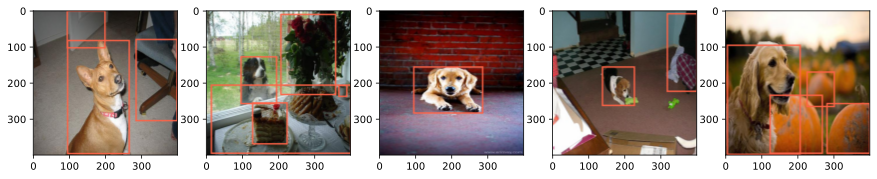

In [ ]:
score_threshold = 0.8
dogs_with_boxes = [
    draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4, colors='tomato')
    for dog_int, output in zip(batch_int, outputs)
]
show(dogs_with_boxes)

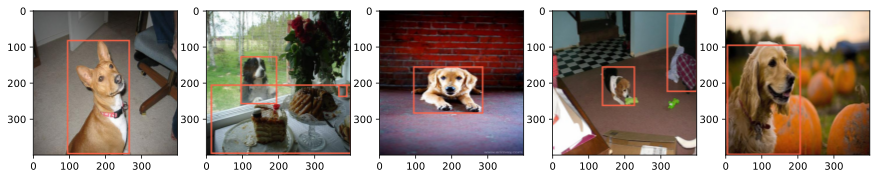

In [ ]:
score_threshold = 0.95
dogs_with_boxes = [
    draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=4, colors='tomato')
    for dog_int, output in zip(batch_int, outputs)
]
show(dogs_with_boxes)

<font face = "Corbel"> As we can see from those images the objects detected are not always dogs, but if we incrase the score threshold it's more probable to idetify dogs. Anyway for the neural networks models used for Image classification it's better if we crop the images using the information that we already have. If we did not have informations about the 

Using fasterrcnn_resnet50_fpn could be a good solution with a dataset with no information about the bounding boxes. 

# <font face = "Corbel light" size = "6" color ="firebrick"> **Load the data**

<font face = "Corbel"> Now we start to prepare the data for training and testing NN models.

<font face = "Corbel"> The images have to be transformed, first of all we had to resize to 224 in order to use the following neural networks, then we have to normalize but to do that we should know from the dataset the mean and the standard deviation of the images for all the channels (R,B,G). In this way, our input images have a size 224x224x3. Since the calculations would be expensive and time consuming, and since the images we have are the same as the basic ones in the ImageNet database, we can use the standard normalization with mean [0.485, 0.456, 0.406] and standard deviation [0.229, 0.224, 0.225]. This normalization transforms each channel of the input torch.Tensor as $output[channel] = \frac{input[channel] - mean[channel]}{std[channel]}$


<font face = "Corbel"> We decided to only resize the images and not to crop them 
since we had already cropped them using the boundary boxes.

<font face = "Corbel"> Finally, since we have few data for each category, to reduce overfitting we decided to do **Data Augmentation**: it is a strategy to significantly increase the diversity of data, in our case by flipping the images horizontally (not vertically since vertically doesn't mean much for dogs), and distorting them.

In [9]:
data_transform = transforms.Compose([                      
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(0.6), 
    transforms.RandomPerspective(distortion_scale = 0.5, p=0.6), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

<font face = "Corbel"> We used ImageFolder to create a dataset taking the previous cropped and transformed images from the Drive folder and the correct labels.

In [10]:
my_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Advanced Programming/Dati dogs/data',
                                  transform=data_transform)

<font face = "Corbel"> As previous we rename the classes

In [11]:
name_classes = []
for element in my_dataset.classes:
  name_classes.append(element.split('-')[1])

In [12]:
my_dataset.classes = name_classes

<font face = "Corbel"> Visualization of 5 transformed images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Function to show some random images
def imshow(img, single = False):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if single == True:
      fig = plt.figure(figsize=(3, 3))
    else:
      fig = plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


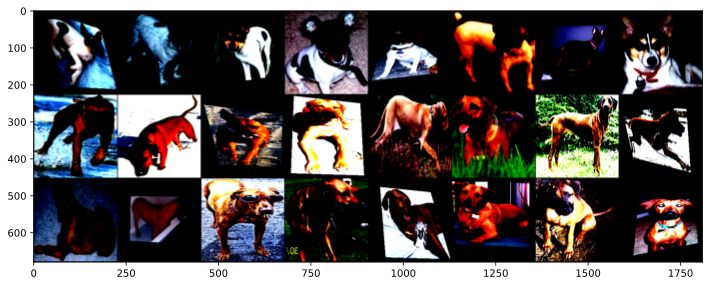

In [ ]:
images = []
for i in range(24):
  images.append(my_dataset[1500+i][0])
imshow(torchvision.utils.make_grid(images))

We can notice that if we run the same code again the images are the same but some of them are transformed for the data augmentation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


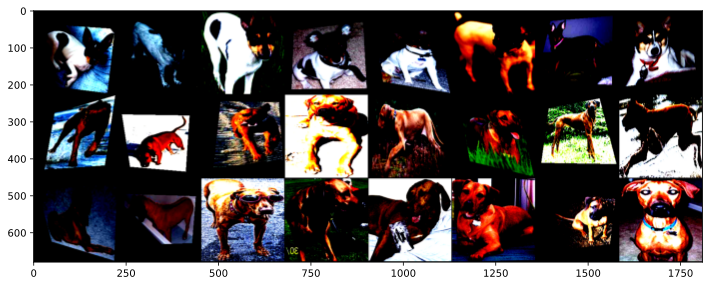

In [ ]:
images = []
for i in range(24):
  images.append(my_dataset[1500+i][0])
imshow(torchvision.utils.make_grid(images))

## <font face = "Corbel light" size = "5" color ="tomato"> **Divide into train and test** 

<font face = "Corbel"> We took 80% of the images for the training, so 16464, and 20% for the test, so the remaining 4116.

In [ ]:
train_size = int(0.8 * len(my_dataset))  # train 0.8
test_size = len(my_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(my_dataset, [train_size, test_size])

In [ ]:
len(train_dataset), len(test_dataset), len(my_dataset)

(16464, 4116, 20580)

<font face = "Corbel"> We checked if the number of images for training and test dataset for each category are balanced.

In [ ]:
# train
calculate = False
if calculate:
  a = []
  i=0
  for key, value in train_dataset:
    if i%1000 == 0:
      print(i) 
    a.append(value)
    i += 1
  
  # save
  textfile = open("/content/drive/MyDrive/Advanced Programming/Dati dogs/count_train_per_class.txt", "w")
  for element in a:
    textfile.write(str(element) + "\n")
  textfile.close()

In [ ]:
# test
calculate = False
if calculate:
  a = []
  i=0
  for key, value in test_dataset:
    if i%1000 == 0:
      print(i) 
    a.append(value)
    i += 1
  
  # save
  textfile = open("/content/drive/MyDrive/Advanced Programming/Dati dogs/count_test_per_class.txt", "w")
  for element in a:
    textfile.write(str(element) + "\n")
  textfile.close()

In [ ]:
train_len_class = open("/content/drive/MyDrive/Advanced Programming/Dati dogs/count_train_per_class.txt", "r")
train_len_class = train_len_class.read().split()
for i in range(0, len(train_len_class)):
  train_len_class[i] = int(train_len_class[i])
  
test_len_class = open("/content/drive/MyDrive/Advanced Programming/Dati dogs/count_test_per_class.txt", "r")
test_len_class = test_len_class.read().split()
for i in range(0, len(test_len_class)):
  test_len_class[i] = int(test_len_class[i])

In [ ]:
df_train = pd.DataFrame({'Classes': train_len_class,'count':[1]*len(train_len_class)})
df_test = pd.DataFrame({'Classes': test_len_class,'count':[1]*len(test_len_class)})
new_df = pd.DataFrame({'Breeds': name_classes,'Count train': df_train.groupby(['Classes']).sum()['count'], 'Count test': df_test.groupby(['Classes']).sum()['count']})
new_df

,Breeds,Count train,Count test
Classes,,,
0,Chihuahua,121,33
1,Japanese_spaniel,151,43
2,Maltese_dog,195,49
3,Pekinese,122,26
4,Shih_Tzu,173,43
...,...,...,...
115,standard_poodle,130,32
116,Mexican_hairless,120,34
117,dingo,128,30


<font face = "Corbel"> Let's define the **Dataloader** that will feed  the data in batches to the neural network.
Dataloader is used to for creating training and testing dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, so the amount of dataloaded to the memory and then passed to the neural network needs to be controlled using parameters such as *batch_size* (batch_size controls how many samples per batch to load). Dataloader is a construct of PyTorch library.

In [ ]:
from torch.utils import data
batch_size = 16
train_dataloader = data.DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers=2)
test_dataloader = data.DataLoader(test_dataset, batch_size = 16, shuffle = False, num_workers=2)

In [ ]:
train_iter = iter(train_dataloader)
test_iter = iter(test_dataloader)
X, y = next(train_iter)  # get one minibatch

print(my_dataset[0][0].shape)
print(X.shape) # X is (batch_size, channels, img height, img width)
print(X[0].shape) # one image in proper channel(s)
print(y.shape)
print(y) # y: 0-based index values representing class labels of the minibatch
print(torch.is_tensor(X[0]))

torch.Size([3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([16])
tensor([ 85,  74, 111,  25,  82,  51,  64,  29,  88,  67,  39,  39,  31,  38,
         17,  67])
True


## <font face = "Corbel light" size = "5" color ="tomato"> **Define useful functions to train and test the model**

<font face = "Corbel"> We define a function to train the model. The outputs are two lists to save the accuracy and the loss for each epoch. 

In [ ]:
import copy
train_loss = []
train_accu = []

def train(epoch, model):
    print('\nEpoch : %d'%epoch)
    running_loss = 0.0
    steps = 0
    correct = 0
    total = 0
    best_model = copy.deepcopy(model.state_dict())

    model.train()
    for i, data in enumerate(train_dataloader, 0):             
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #loss
        running_loss += loss.item()
        steps += 1
        #accuracy
        _, predicted = torch.max(outputs.data, dim=1)
        correct += (predicted==labels).sum().item()
        total+=labels.size(0)
        best_model = copy.deepcopy(model.state_dict()) 

        # print statistics
        if i % 100 == 0:    # print every 100 mini-batches
            print('[batch: %d] train loss: %.3f, train accuracy: %.2f %%' %( i + 1, running_loss / steps, (correct*100)/total))
            running_loss = 0.0
     
    epoch_loss = running_loss/steps  
    train_loss.append(epoch_loss) 
    
    epoch_accu = (correct*100)/total
    train_accu.append(epoch_accu)
    print('\n [EPOCH %d] train loss: %.3f, train accuracy: %.2f %%' %( epoch, running_loss / steps, (correct*100)/total))

    return train_loss, train_accu
  

<font face = "Corbel"> We define a function to test our model on some data that was not seen before by the model. The function outputs the test accuracy and the predicted labels for each image.

In [4]:
def test(model):
  correct = 0
  total = 0
  predictions = []
  model.eval()
  with torch.no_grad():
    for data in test_dataloader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          
          #find predictions
          predictions.extend(predicted)
          #accuracy
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
  test_accuracy = (correct*100)/total
  predictions = torch.stack(predictions).cpu()  
  return predictions, test_accuracy

<font face = "Corbel"> We alse defined the accuracy for each class of the model in the following function. 

In [ ]:
def test_accuracy_per_class(model, name_classes):
  n_classes = len(name_classes)
  class_correct = list(0. for i in range(n_classes))
  class_total = list(0. for i in range(n_classes))
  accuracy = list(0. for i in range(n_classes))
  with torch.no_grad():
    for data in test_dataloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1) 
      for label, pred in zip(labels, predicted):
        if label == pred:
          class_correct[label] += 1
        class_total[label] += 1
        
  for i in range(n_classes):
    if class_total[i] > 0:
          accuracy[i] = 100 * class_correct[i] / class_total[i]
    else:
          accuracy[i] = 0

  return accuracy

# <font face = "Corbel light" size = "6" color ="firebrick"> **Alexnet - not pretrained**

<font face = "Corbel"> The first model we implemented is AlexNet. 

AlexNet is a CNN architecture that consists of **5** two-dimensional **convolution layers**, followed by **3 fully connected layers**, total of eight layers. 

The convolution layers uses trainable kernels or filters to perform convolution operations, which involves moving the kernels over the input in steps called strides. The output is then passed through a non-linearity **ReLu activation function**. Some convolutional layers are followed by a **Max Pooling layer**, which helps reducing overfitting and uses kernels of dimension 3x3. 

The first two fully connected layers have a **dropout layer** associated with them, with a dropout ratio of 0.5, which also help reducing overfitting. The final fully connected layer has **120 outputs** because of the number of our classes.

In [ ]:
#DEFINE THE NUMBER OF CLASSES 
n_classes = 120

<font face = "Corbel"> We uploaded the model from the pytorch website. 

In [ ]:
#Now using the AlexNet
AlexNet_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)

#Model description
AlexNet_model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

<font face = "Corbel"> Since we want a model that classifies 120 classes, we changed the last layer in order to have the output size equal to 120. We also update the previous linear layer in order to smooth the resizing of the output. 

In [ ]:
AlexNet_model.classifier[4] = nn.Linear(4096,1024)
AlexNet_model.classifier[6] = nn.Linear(1024, n_classes)

<font face = "Corbel"> We now verify the device where the model is running and we move the input and AlexNet_model to GPU for speed, if available.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

AlexNet_model.to(device)

cpu


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

<font face = "Corbel"> Here we define the loss function and optimizer. 
The *criterion* is used the calculate the difference in the output created by the model and the actual output. We use the cross entropy loss function since we are doing a classification task. The *Optimizer* is used to update the weights of the neural network to improve its performance. As optimizer we use stochastic gradient descent.

In [ ]:
#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)

## <font face = "Corbel light" size = "5" color ="tomato"> **Training the model**

<font face = "Corbel"> Let's train our model. We set the number of epochs and a early stopping value to stop our model in case there is not great improvement in the accuracy.

In [ ]:
%%time
Early_stopping_value = 0.00001
EPOCHS = 100
train_accu = []
train_loss = []

for epoch in range(1, EPOCHS+1):     # loop over the dataset multiple times
  train(epoch, AlexNet_model)

  if epoch > 2:
    if abs(train_accu[epoch-2] - train_accu[epoch-1]) < Early_stopping_value:
      print("\nEarly stopping. Epoch:", epoch)
      break 

print('\nFinished Training of AlexNet')


Epoch : 1
[batch: 1] train loss: 4.796, train accuracy: 0.00 %
[batch: 101] train loss: 4.740, train accuracy: 1.11 %
[batch: 201] train loss: 2.381, train accuracy: 1.24 %
[batch: 301] train loss: 1.590, train accuracy: 1.20 %
[batch: 401] train loss: 1.194, train accuracy: 1.15 %
[batch: 501] train loss: 0.955, train accuracy: 1.09 %
[batch: 601] train loss: 0.797, train accuracy: 1.10 %
[batch: 701] train loss: 0.683, train accuracy: 1.08 %
[batch: 801] train loss: 0.598, train accuracy: 1.08 %
[batch: 901] train loss: 0.531, train accuracy: 1.09 %
[batch: 1001] train loss: 0.478, train accuracy: 1.09 %

 [EPOCH 1] train loss: 0.130, train accuracy: 1.10 %

Epoch : 2
[batch: 1] train loss: 4.791, train accuracy: 0.00 %
[batch: 101] train loss: 4.738, train accuracy: 0.56 %
[batch: 201] train loss: 2.380, train accuracy: 0.96 %
[batch: 301] train loss: 1.589, train accuracy: 1.04 %
[batch: 401] train loss: 1.193, train accuracy: 1.12 %
[batch: 501] train loss: 0.954, train accuracy:

<font face = "Corbel"> Let's save the model

In [ ]:
%%capture
import pickle
#with open('/content/drive/MyDrive/Advanced Programming/alexnet_model1_final', 'wb') as files:
#  pickle.dump(AlexNet_model, files)

with open('/content/drive/MyDrive/Advanced Programming/alexnet_model1' , 'rb') as f:
  AlexNet_model = pickle.load(f)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
AlexNet_model.to(device)

In [ ]:
#with open('/content/drive/MyDrive/Advanced Programming/train_accu_alexnet1_final', 'wb') as files:
 # pickle.dump(train_accu, files)

with open('/content/drive/MyDrive/Advanced Programming/train_accu_alexnet1' , 'rb') as f:
  train_accu = pickle.load(f)

In [ ]:
with open('/content/drive/MyDrive/Advanced Programming/train_loss_alexnet1_final', 'wb') as files:
  pickle.dump(train_loss, files)

#with open('/content/drive/MyDrive/Advanced Programming/train_loss_alexnet1_final' , 'rb') as f:
  #train_loss = pickle.load(f)

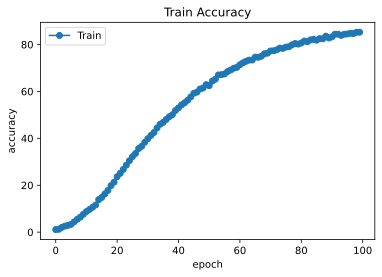

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Image

display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.plot(train_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train'])
plt.title('Train Accuracy')
 
plt.show()

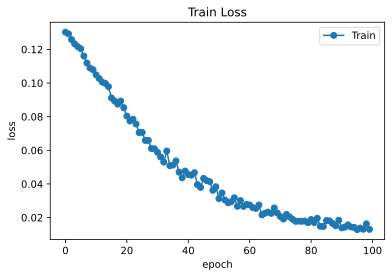

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.plot(train_loss,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train'])
plt.title("Train Loss")
 
plt.show()

## <font face = "Corbel light" size = "5" color ="tomato"> **Testing the model**


In [ ]:
t = test(AlexNet_model)
predictions, acc = t[0], t[1]
print('Accuracy of the network on the test images: %.2f %%' % acc)

Accuracy of the network on the test images: 85.59 %


In [ ]:
#Testing classification accuracy for individual classes.

acc = test_accuracy_per_class(AlexNet_model, name_classes)
for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' %(name_classes[i],acc[i]) )
    

Accuracy of Chihuahua : 80 %
Accuracy of Japanese_spaniel : 91 %
Accuracy of Maltese_dog : 88 %
Accuracy of Pekinese : 96 %
Accuracy of Shih_Tzu : 82 %
Accuracy of Blenheim_spaniel : 92 %
Accuracy of papillon : 93 %
Accuracy of toy_terrier : 80 %
Accuracy of Rhodesian_ridgeback : 76 %
Accuracy of Afghan_hound : 90 %
Accuracy of basset : 73 %
Accuracy of beagle : 89 %
Accuracy of bloodhound : 91 %
Accuracy of bluetick : 93 %
Accuracy of black_and_tan_coonhound : 87 %
Accuracy of Walker_hound : 90 %
Accuracy of English_foxhound : 93 %
Accuracy of redbone : 86 %
Accuracy of borzoi : 83 %
Accuracy of Irish_wolfhound : 87 %
Accuracy of Italian_greyhound : 80 %
Accuracy of whippet : 79 %
Accuracy of Ibizan_hound : 85 %
Accuracy of Norwegian_elkhound : 86 %
Accuracy of otterhound : 85 %
Accuracy of Saluki : 77 %
Accuracy of Scottish_deerhound : 84 %
Accuracy of Weimaraner : 89 %
Accuracy of Staffordshire_bullterrier : 70 %
Accuracy of American_Staffordshire_terrier : 71 %
Accuracy of Bedlingt

In [ ]:
#with open('/content/drive/MyDrive/Advanced Programming/pred_alexnet1_final', 'wb') as files:
#  pickle.dump(predictions, files)

with open('/content/drive/MyDrive/Advanced Programming/pred_alexnet1' , 'rb') as f:
  predictions = pickle.load(f)

# <font face = "Corbel light" size = "6" color ="firebrick"> **AlexNet pretrained - as fixed feature extractor**

<font face = "Corbel"> 
We were curious to see what are the differences with a pretrained model.

**Transfer learning** is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

It is common to use a pretrained ConvNet on a very large dataset (for us the model is pretrained by PyTorch on ImageNet, which contains 1.2 million images with 1000 categories), and then use that ConvNet as a fixed feature extractor for the task of interest. 

One of the major Transfer Learning scenarios is fixed **feature extractor**.  Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset. 

The second strategy is to not only replace and retrain the classifier on top of the ConvNet on the new dataset, but to also **fine-tune** the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. This is motivated by the observation that the earlier features of a ConvNet contain more generic features that should be useful to many tasks, but later layers of the ConvNet becomes progressively more specific to the details of the classes contained in the original dataset.

Since the **data is very small** for each category, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. Since the **data is similar to the original data** (our dataset has been built using images and annotation from ImageNet) , we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to have a fixed feature extractor and train a linear classifier on the CNN codes. 

(Source Note: the code for using a pretrained model is from this link https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#helper-functions ) 


In [ ]:
# Flag for feature extracting. When False, we finetune the whole model, 
# when True we only update the reshaped layer params
feature_extract = True

AlexNet_model2 = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

#Model description
AlexNet_model2.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

<font face = "Corbel"> Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last layer is replaced with a new one with random weights and only this layer is trained. We need to set *requires_grad = False* to freeze the parameters so that the gradients are not computed in *backward()*.   Parameters of newly constructed modules have *requires_grad=True* by default.

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(AlexNet_model2, feature_extract)
num_ftrs = AlexNet_model2.classifier[6].in_features
AlexNet_model2.classifier[6] = nn.Linear(num_ftrs, n_classes)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

AlexNet_model2.to(device)

cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#Loss
criterion = nn.CrossEntropyLoss()

<font face = "Corbel"> Here, we will specify to the optimizer to only update the weight of the parameters in the list *parameters_to_update.* In fact, we will train only the final layer of the model. 

In [ ]:
params_to_update = AlexNet_model2.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in AlexNet_model2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in AlexNet_model2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


## <font face = "Corbel light" size = "5" color ="tomato"> **Training the model**

In [ ]:
%%time
Early_stopping_value = 0.0001
EPOCHS = 75
train_accu = []
train_loss = []

for epoch in range(1, EPOCHS+1):     # loop over the dataset multiple times
  train(epoch, AlexNet_model2)

  if epoch > 2:
    if abs(train_accu[epoch-2] - train_accu[epoch-1]) < Early_stopping_value:
      print("\nEarly stopping. Epoch:", epoch)
      break 

print('\nFinished Training of AlexNet')


Epoch : 1
[batch: 1] train loss: 5.061, train accuracy: 0.00 %
[batch: 101] train loss: 3.602, train accuracy: 19.93 %
[batch: 201] train loss: 1.280, train accuracy: 27.58 %
[batch: 301] train loss: 0.773, train accuracy: 31.33 %
[batch: 401] train loss: 0.557, train accuracy: 33.67 %
[batch: 501] train loss: 0.444, train accuracy: 35.29 %
[batch: 601] train loss: 0.347, train accuracy: 36.99 %
[batch: 701] train loss: 0.284, train accuracy: 38.47 %
[batch: 801] train loss: 0.272, train accuracy: 39.10 %
[batch: 901] train loss: 0.235, train accuracy: 39.75 %
[batch: 1001] train loss: 0.206, train accuracy: 40.28 %

 [EPOCH 1] train loss: 0.057, train accuracy: 40.39 %

Epoch : 2
[batch: 1] train loss: 2.046, train accuracy: 31.25 %
[batch: 101] train loss: 1.769, train accuracy: 52.54 %
[batch: 201] train loss: 0.916, train accuracy: 51.96 %
[batch: 301] train loss: 0.590, train accuracy: 52.43 %
[batch: 401] train loss: 0.464, train accuracy: 52.15 %
[batch: 501] train loss: 0.366,

In [ ]:
%%capture
import pickle
#with open('/content/drive/MyDrive/Advanced Programming/alexnet_model2_final', 'wb') as files:
#  pickle.dump(AlexNet_model2, files)

with open('/content/drive/MyDrive/Advanced Programming/alexnet_model2_final' , 'rb') as f:
  AlexNet_model2 = pickle.load(f)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
AlexNet_model2.to(device)

In [ ]:
#with open('/content/drive/MyDrive/Advanced Programming/train_accu_alexnet2_final', 'wb') as files:
  #pickle.dump(train_accu, files)

with open('/content/drive/MyDrive/Advanced Programming/train_accu_alexnet2_final' , 'rb') as f:
  train_accu = pickle.load(f)

In [ ]:
#with open('/content/drive/MyDrive/Advanced Programming/train_loss_alexnet2_final', 'wb') as files:
 # pickle.dump(train_loss, files)

with open('/content/drive/MyDrive/Advanced Programming/train_loss_alexnet2_final' , 'rb') as f:
  train_loss = pickle.load(f)

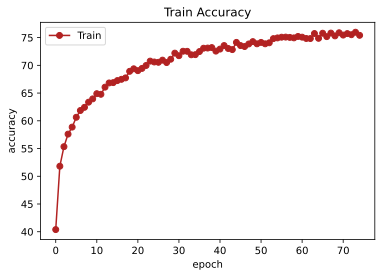

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Image

display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.plot(train_accu,'-o', color = "firebrick")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train'])
plt.title('Train Accuracy')
 
plt.show()

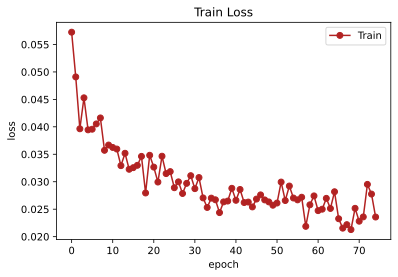

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.plot(train_loss,'-o', color = "firebrick")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train'])
plt.title("Train Loss")
 
plt.show()

## <font face = "Corbel light" size = "5" color ="tomato"> **Testing the model**

In [ ]:
t = test(AlexNet_model2)
predictions2, acc = t[0], t[1]
print('Accuracy of the network on the test images: %.2f %%' % acc)

Accuracy of the network on the test images: 82.09 %


In [ ]:
#Testing classification accuracy for individual classes.
acc = test_accuracy_per_class(AlexNet_model2, name_classes)
for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' %(name_classes[i],acc[i]) )
    

Accuracy of Chihuahua : 86 %
Accuracy of Japanese_spaniel : 91 %
Accuracy of Maltese_dog : 86 %
Accuracy of Pekinese : 78 %
Accuracy of Shih_Tzu : 52 %
Accuracy of Blenheim_spaniel : 90 %
Accuracy of papillon : 86 %
Accuracy of toy_terrier : 86 %
Accuracy of Rhodesian_ridgeback : 60 %
Accuracy of Afghan_hound : 84 %
Accuracy of basset : 81 %
Accuracy of beagle : 86 %
Accuracy of bloodhound : 91 %
Accuracy of bluetick : 93 %
Accuracy of black_and_tan_coonhound : 81 %
Accuracy of Walker_hound : 70 %
Accuracy of English_foxhound : 90 %
Accuracy of redbone : 86 %
Accuracy of borzoi : 83 %
Accuracy of Irish_wolfhound : 89 %
Accuracy of Italian_greyhound : 76 %
Accuracy of whippet : 66 %
Accuracy of Ibizan_hound : 81 %
Accuracy of Norwegian_elkhound : 94 %
Accuracy of otterhound : 74 %
Accuracy of Saluki : 70 %
Accuracy of Scottish_deerhound : 80 %
Accuracy of Weimaraner : 92 %
Accuracy of Staffordshire_bullterrier : 91 %
Accuracy of American_Staffordshire_terrier : 75 %
Accuracy of Bedlingt

In [ ]:
#with open('/content/drive/MyDrive/Advanced Programming/pred_alexnet2_final', 'wb') as files:
#  pickle.dump(predictions2, files)

with open('/content/drive/MyDrive/Advanced Programming/pred_alexnet2_final' , 'rb') as f:
  predictions2 = pickle.load(f)

## <font face = "Corbel light" size = "5" color ="tomato"> **An example**

<font face = "Corbel"> Let's have a look at an example. We load two random images and see if our model is able to predict the breeds in the pictures. 

In [ ]:
imageA, labelA = test_dataset[20][0], test_dataset[20][1]
predA1 = predictions[20]
predA2 = predictions2[20]
imageB, labelB = test_dataset[60][0], test_dataset[60][1]
predB1 = predictions[60] 
predB2 = predictions2[60] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


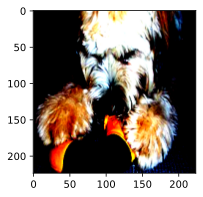

Correct label: soft_coated_wheaten_terrier 
 Predicted label model 1: soft_coated_wheaten_terrier 
 Predicted label model 2: soft_coated_wheaten_terrier


In [ ]:
imshow(imageA, single = True)
print('Correct label:', name_classes[labelA],"\n Predicted label model 1:", name_classes[predA1],
      "\n Predicted label model 2:", name_classes[predA2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


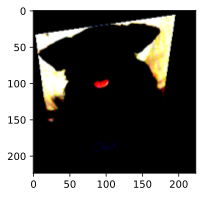

Correct label: standard_schnauzer 
 Predicted label model 1: giant_schnauzer 
 Predicted label model 2: affenpinscher


In [ ]:
imshow(imageB, single=True)
print('Correct label:', name_classes[labelB],"\n Predicted label model 1:",  name_classes[predB1],
      "\n Predicted label model 2:",  name_classes[predB2])  

# <font face = "Corbel light" size = "6" color ="firebrick"> **ResNet 50 - not pretrained**

<font face = "Corbel"> As our second model we decided to use **ResNet 50**. The reason for our choice is that between the pretrained PyTorch models, ResNet 50 has some of the best characteristics, as we can see in the following graph. 

(Source of the picture: https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/)

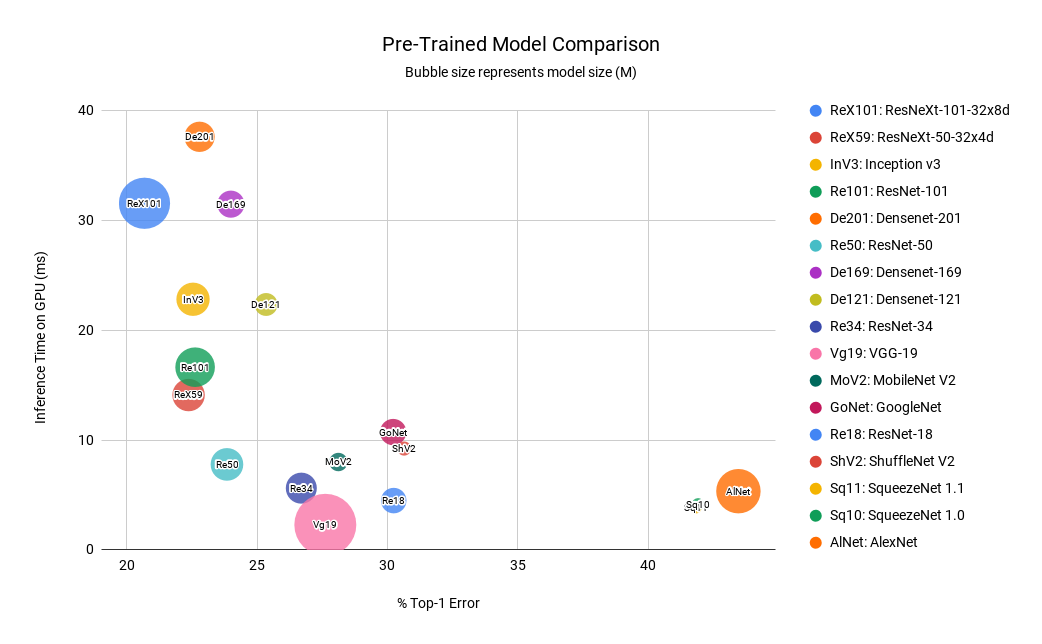

<font face = "Corbel"> Here we can see that ResNet 50 is great because it has the following features:

*   small inference time on GPU
*   small top-1 error (A top-1 error occurs if the class predicted by a model with highest confidence is not the same as the true class).


<font face = "Corbel"> AlexNet is one of the first model created, most recent model are improved version and have lower Top-1 Error. For this reason we expect greater results from ResNet 50 compared to AlexNet. 

ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer.

First we gave in input the images having height, width as 224x224 and 3 as channel width. The first layer we have is a convolution layer using 7x7 kernel size followed by a max pooling layer with 3x3 kernel size. Then we can divide the architecture of Resnet50 in 4 stages.

Stage 1 of the network starts and it has 3 Residual blocks containing 3 layers each. The size of kernels used to perform the convolution operation in all 3 layers of the block of stage 1 are 64, 64 and 128 respectively. 

As we progress from one stage to another, the channel width is doubled and the size of the input is reduced to half. For each residual function, 3 layers are stacked one over the other. The three layers are 1×1, 3×3, 1×1 convolutions. The 1×1 convolution layers are responsible for reducing and then restoring the dimensions. The 3×3 layer is left as a bottleneck with smaller input/output dimensions.

Finally, the network has an Average Pooling layer followed by a fully connected layer having 120 neurons, the number of classes (ImageNet class output).


<font face = "Corbel"> We import ResNet 50 from the Pytorch website.

In [ ]:
ResNet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)

#Model description
ResNet_model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<font face = "Corbel"> In order to have a model for classification on 120 classes, we changed the last linear layer of ResNet50 to a layer with an output size equal to 120. 

In [ ]:
ResNet_model.fc = nn.Linear(2048, n_classes)

<font face = "Corbel"> We now verify the device where the model is running and we move the input and ResNet_model to GPU for speed, if available.

In [ ]:
import torch
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

ResNet_model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<font face = "Corbel"> As loss function we use the Cross Entropy function, and as optimizer we use stochastic gradient descent.

In [ ]:
#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(ResNet_model.parameters(), lr=0.001, momentum=0.9)

## <font face = "Corbel light" size = "5" color ="tomato"> **Training the model**

<font face = "Corbel"> Let's train our model with the previously defined function. We set the number of epochs and a early stopping value to stop our model in case there is not great improvement in the accuracy. 

In [ ]:
%%time

Early_stopping_value = 0.00001
EPOCHS = 100
train_accu = []
train_loss = []

for epoch in range(1, EPOCHS + 1):     # loop over the dataset multiple times
  train(epoch, ResNet_model)
  if epoch > 2:
    if abs(train_accu[epoch-2] - train_accu[epoch-1]) < Early_stopping_value:
      print("\nEarly stopping. Epoch:", epoch)
      break 

print('\nFinished Training of my model')


Epoch : 1
[batch: 1] train loss: 5.044, train accuracy: 0.00 %
[batch: 101] train loss: 5.029, train accuracy: 0.93 %
[batch: 201] train loss: 2.538, train accuracy: 0.87 %
[batch: 301] train loss: 1.688, train accuracy: 0.93 %
[batch: 401] train loss: 1.252, train accuracy: 0.94 %
[batch: 501] train loss: 0.995, train accuracy: 0.99 %
[batch: 601] train loss: 0.831, train accuracy: 1.02 %
[batch: 701] train loss: 0.699, train accuracy: 1.05 %
[batch: 801] train loss: 0.612, train accuracy: 1.18 %
[batch: 901] train loss: 0.541, train accuracy: 1.17 %
[batch: 1001] train loss: 0.480, train accuracy: 1.22 %

 [EPOCH 1] train loss: 0.132, train accuracy: 1.23 %

Epoch : 2
[batch: 1] train loss: 5.169, train accuracy: 6.25 %
[batch: 101] train loss: 4.708, train accuracy: 2.23 %
[batch: 201] train loss: 2.360, train accuracy: 2.05 %
[batch: 301] train loss: 1.563, train accuracy: 2.49 %
[batch: 401] train loss: 1.168, train accuracy: 2.34 %
[batch: 501] train loss: 0.932, train accuracy:

<font face = "Corbel"> Let's save our model

In [5]:
%%capture
import pickle
#with open('/content/drive/MyDrive/Advanced Programming/resnet_model1_final', 'wb') as files:
#  pickle.dump(ResNet_model, files)

with open('/content/drive/MyDrive/Advanced Programming/resnet_model1_final' , 'rb') as f:
  ResNet_model = pickle.load(f)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ResNet_model.to(device)

In [ ]:
#with open('/content/drive/MyDrive/Advanced Programming/train_accu_resnet1_final', 'wb') as files:
#  pickle.dump(train_accu, files)

with open('/content/drive/MyDrive/Advanced Programming/train_accu_resnet1_final' , 'rb') as f:
  train_accu = pickle.load(f)

In [ ]:
#with open('/content/drive/MyDrive/Advanced Programming/train_loss_resnet1_final', 'wb') as files:
#  pickle.dump(train_loss, files)

with open('/content/drive/MyDrive/Advanced Programming/train_loss_resnet1_final' , 'rb') as f:
  train_loss = pickle.load(f)

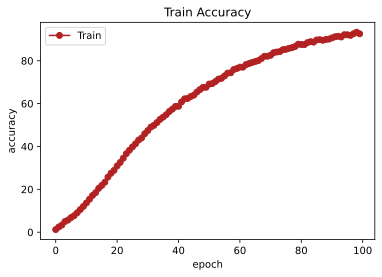

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Image

display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.plot(train_accu,'-o', color = "firebrick")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train'])
plt.title('Train Accuracy')
 
plt.show()

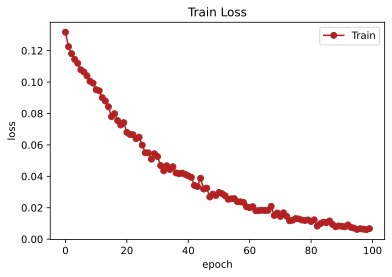

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.plot(train_loss,'-o', color = "firebrick")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train'])
plt.title("Train Loss")
 
plt.show()

## <font face = "Corbel light" size = "5" color ="tomato"> **Testing the model**

<font face = "Corbel"> Let's compute the total accuracy of the model and the accuracy for each class. 

In [ ]:
predictions = []
t = test(ResNet_model) 
predictions, acc = t[0], t[1]
print('Accuracy of the network on the test images: %.2f %%' % acc)

Accuracy of the network on the test images: 87.83 %


In [ ]:
#Testing classification accuracy for individual classes.

acc = test_accuracy_per_class(ResNet_model, name_classes)
for i in range(n_classes):
    print('Accuracy of %5s : %.2f %%' %(name_classes[i],acc[i]) )
    

Accuracy of Chihuahua : 92.86 %
Accuracy of Japanese_spaniel : 96.55 %
Accuracy of Maltese_dog : 86.00 %
Accuracy of Pekinese : 86.21 %
Accuracy of Shih_Tzu : 77.59 %
Accuracy of Blenheim_spaniel : 90.32 %
Accuracy of papillon : 86.67 %
Accuracy of toy_terrier : 81.82 %
Accuracy of Rhodesian_ridgeback : 85.71 %
Accuracy of Afghan_hound : 97.62 %
Accuracy of basset : 86.84 %
Accuracy of beagle : 94.12 %
Accuracy of bloodhound : 78.95 %
Accuracy of bluetick : 97.73 %
Accuracy of black_and_tan_coonhound : 89.29 %
Accuracy of Walker_hound : 83.33 %
Accuracy of English_foxhound : 90.32 %
Accuracy of redbone : 78.79 %
Accuracy of borzoi : 96.97 %
Accuracy of Irish_wolfhound : 82.35 %
Accuracy of Italian_greyhound : 94.44 %
Accuracy of whippet : 94.29 %
Accuracy of Ibizan_hound : 95.00 %
Accuracy of Norwegian_elkhound : 91.18 %
Accuracy of otterhound : 86.49 %
Accuracy of Saluki : 94.74 %
Accuracy of Scottish_deerhound : 96.00 %
Accuracy of Weimaraner : 96.43 %
Accuracy of Staffordshire_bullt

<font face = "Corbel"> We save also the predictions

In [ ]:
#with open('/content/drive/MyDrive/Advanced Programming/pred_resnet1_final', 'wb') as files:
#  pickle.dump(predictions, files)

with open('/content/drive/MyDrive/Advanced Programming/pred_resnet1' , 'rb') as f:
  predictions = pickle.load(f)

# <font face = "Corbel light" size = "6" color ="firebrick"> **ResNet 50 pretrained - as fixed feature extractor**

<font face = "Corbel"> Now we try to improve the results with a fixed feature extractor from the pretrained model of ResNet50. For the same reasons stated for pretrained AlexNet as a fixed feature extractor, we expect greater accuracy. 

In [ ]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

ResNet_model2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

#Model description
ResNet_model2.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(ResNet_model2, feature_extract)
ResNet_model2.fc = nn.Linear(2048, n_classes)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

ResNet_model2.to(device)

cpu


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#Loss
criterion = nn.CrossEntropyLoss()

In [ ]:
params_to_update = ResNet_model2.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in ResNet_model2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in ResNet_model2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


## <font face = "Corbel light" size = "5" color ="tomato"> **Training the model**

In [ ]:
%%time
Early_stopping_value = 0.00001
EPOCHS = 75
train_accu = []
train_loss = []

for epoch in range(1, EPOCHS+1):     # loop over the dataset multiple times
  train(epoch, ResNet_model2)

  if epoch > 2:
    if abs(train_accu[epoch-2] - train_accu[epoch-1]) < Early_stopping_value:
      print("\nEarly stopping. Epoch:", epoch)
      break 

print('\nFinished Training of ResNet')


Epoch : 1
[batch: 1] train loss: 5.112, train accuracy: 0.00 %
[batch: 101] train loss: 4.587, train accuracy: 5.75 %
[batch: 201] train loss: 2.040, train accuracy: 13.31 %
[batch: 301] train loss: 1.214, train accuracy: 19.93 %
[batch: 401] train loss: 0.809, train accuracy: 25.53 %
[batch: 501] train loss: 0.578, train accuracy: 30.39 %
[batch: 601] train loss: 0.432, train accuracy: 34.46 %
[batch: 701] train loss: 0.340, train accuracy: 37.90 %
[batch: 801] train loss: 0.267, train accuracy: 41.25 %
[batch: 901] train loss: 0.227, train accuracy: 43.82 %
[batch: 1001] train loss: 0.189, train accuracy: 46.04 %

 [EPOCH 1] train loss: 0.050, train accuracy: 46.54 %

Epoch : 2
[batch: 1] train loss: 1.772, train accuracy: 75.00 %
[batch: 101] train loss: 1.671, train accuracy: 69.62 %
[batch: 201] train loss: 0.814, train accuracy: 69.53 %
[batch: 301] train loss: 0.511, train accuracy: 69.85 %
[batch: 401] train loss: 0.383, train accuracy: 69.75 %
[batch: 501] train loss: 0.288, 

In [ ]:
%%capture
import pickle
#with open('/content/drive/MyDrive/Advanced Programming/resnet_model2_final', 'wb') as files:
#  pickle.dump(ResNet_model2, files)

with open('/content/drive/MyDrive/Advanced Programming/resnet_model2_final' , 'rb') as f:
  ResNet_model2 = pickle.load(f)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ResNet_model2.to(device)

In [ ]:
#with open('/content/drive/MyDrive/Advanced Programming/train_accu_resnet2_final', 'wb') as files:
#  pickle.dump(train_accu, files)

with open('/content/drive/MyDrive/Advanced Programming/train_accu_resnet2_final' , 'rb') as f:
  train_accu = pickle.load(f)

In [ ]:
#with open('/content/drive/MyDrive/Advanced Programming/train_loss_resnet2_final', 'wb') as files:
#  pickle.dump(train_loss, files)

with open('/content/drive/MyDrive/Advanced Programming/train_loss_resnet2_final' , 'rb') as f:
  train_loss = pickle.load(f)

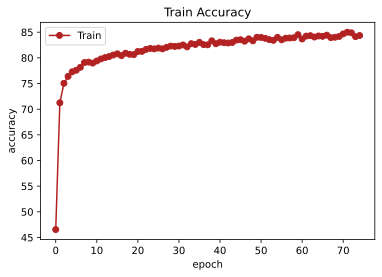

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Image

display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.plot(train_accu,'-o', color = "firebrick")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train'])
plt.title('Train Accuracy')
 
plt.show()

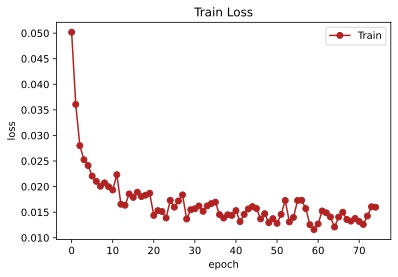

In [ ]:
display(HTML("""
<style>
#output-body {
    display: flex;
    align-items: center;
    justify-content: center;
}
</style>
"""))

plt.plot(train_loss,'-o',color = "firebrick")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train'])
plt.title("Train Loss")
 
plt.show()

## <font face = "Corbel light" size = "5" color ="tomato"> **Testing the model**

In [ ]:
predictions2 = []
t = test(ResNet_model2)
predictions2, acc = t[0], t[1]
print('Accuracy of the network on the test images: %.2f %%' % acc)

Accuracy of the network on the test images: 87.27 %


In [ ]:
#Testing classification accuracy for individual classes.
acc = test_accuracy_per_class(ResNet_model2, name_classes)
for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' %(name_classes[i],acc[i]) )
    

Accuracy of Chihuahua : 83 %
Accuracy of Japanese_spaniel : 86 %
Accuracy of Maltese_dog : 93 %
Accuracy of Pekinese : 100 %
Accuracy of Shih_Tzu : 80 %
Accuracy of Blenheim_spaniel : 92 %
Accuracy of papillon : 83 %
Accuracy of toy_terrier : 80 %
Accuracy of Rhodesian_ridgeback : 93 %
Accuracy of Afghan_hound : 94 %
Accuracy of basset : 86 %
Accuracy of beagle : 86 %
Accuracy of bloodhound : 94 %
Accuracy of bluetick : 96 %
Accuracy of black_and_tan_coonhound : 78 %
Accuracy of Walker_hound : 66 %
Accuracy of English_foxhound : 84 %
Accuracy of redbone : 68 %
Accuracy of borzoi : 91 %
Accuracy of Irish_wolfhound : 82 %
Accuracy of Italian_greyhound : 80 %
Accuracy of whippet : 87 %
Accuracy of Ibizan_hound : 91 %
Accuracy of Norwegian_elkhound : 100 %
Accuracy of otterhound : 81 %
Accuracy of Saluki : 100 %
Accuracy of Scottish_deerhound : 90 %
Accuracy of Weimaraner : 97 %
Accuracy of Staffordshire_bullterrier : 82 %
Accuracy of American_Staffordshire_terrier : 62 %
Accuracy of Bedli

In [ ]:
#with open('/content/drive/MyDrive/Advanced Programming/pred_resnet2_final', 'wb') as files:
#  pickle.dump(predictions2, files)

with open('/content/drive/MyDrive/Advanced Programming/pred_resnet2_final' , 'rb') as f:
  predictions2 = pickle.load(f)

## <font face = "Corbel light" size = "5" color ="tomato"> **An example**

<font face = "Corbel"> Let's have a look at an example. We load two random images and see if our model is able to predict the breeds in the pictures. 

In [ ]:
imageA, labelA = test_dataset[1200][0], test_dataset[1200][1]
predA1 = predictions[1200]
predA2 = predictions2[1200]
imageB, labelB = test_dataset[800][0], test_dataset[800][1]
predB1 = predictions[800] 
predB2 = predictions2[800] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


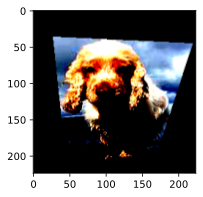

Correct label: cocker_spaniel 
 Predicted label model 1: cocker_spaniel 
 Predicted label model 2: Appenzeller


In [ ]:
imshow(imageA, single = True)
print('Correct label:', name_classes[labelA],"\n Predicted label model 1:", name_classes[predA1],
      "\n Predicted label model 2:", name_classes[predA2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


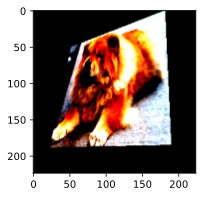

Correct label: chow 
 Predicted label model 1: chow 
 Predicted label model 2: Saint_Bernard


In [ ]:
 imshow(imageB, single=True)
print('Correct label:', name_classes[labelB],"\n Predicted label model 1:",  name_classes[predB1],
      "\n Predicted label model 2:",  name_classes[predB2])  

# <font face = "Corbel light" size = "6" color ="firebrick"> **Our puppies** 

<font face = "Corbel"> Let's see if our model can predict the breeds of our puppies. 

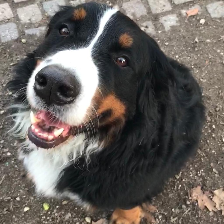

In [6]:
margot0 = cv2.imread('/content/drive/MyDrive/Advanced Programming/Dati dogs/margot.jpg')
margot1 = cv2.resize(margot0, dsize=(224,224),interpolation=cv2.INTER_CUBIC)
margot = torch.from_numpy(cv2.cvtColor(margot1, cv2.COLOR_BGR2RGB)).permute(2,0,1)
F.to_pil_image(margot) 

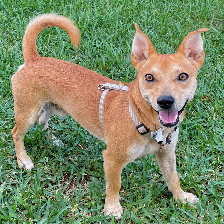

In [7]:
kobe0 = cv2.imread('/content/drive/MyDrive/Advanced Programming/Dati dogs/kobe.jpg')
kobe1 = cv2.resize(kobe0, dsize=(224,224),interpolation=cv2.INTER_CUBIC)
kobe = torch.from_numpy(cv2.cvtColor(kobe1, cv2.COLOR_BGR2RGB)).permute(2,0,1)
F.to_pil_image(kobe) 

In [ ]:
from torchvision.transforms.functional import convert_image_dtype

batch_int = torch.stack([margot.to(device), kobe.to(device)])
batch = convert_image_dtype(batch_int, dtype=torch.float)

outputs = AlexNet_model(batch)
_, predicted = torch.max(outputs.data, 1)

print("Prediction with AlexNet (not pretrained): \n")
print('Correct breed of Margot: Bernese Mountain Dog. Predicted breed:', name_classes[predicted[0]])
print('Correct breed of Kobe: unknown. Predicted breed:', name_classes[predicted[1]])

Prediction with AlexNet (not pretrained): 

Correct breed of Margot: Bernese Mountain Dog. Predicted breed: Afghan_hound
Correct breed of Kobe: unknown. Predicted breed: dhole


In [ ]:
outputs = AlexNet_model2(batch)
_, predicted = torch.max(outputs.data, 1)

print("Prediction with AlexNet (pretrained as fixed features exctractor): \n")
print('Correct breed of Margot: Bernese Mountain Dog. Predicted breed:', name_classes[predicted[0]])
print('Correct breed of Kobe: unknown. Predicted breed:', name_classes[predicted[1]])

Prediction with AlexNet (pretrained as fixed features exctractor): 

Correct breed of Margot: Bernese Mountain Dog. Predicted breed: Gordon_setter
Correct breed of Kobe: unknown. Predicted breed: dhole


In [13]:
from torchvision.transforms.functional import convert_image_dtype

batch_int = torch.stack([margot.to(device), kobe.to(device)])
batch = convert_image_dtype(batch_int, dtype=torch.float)
outputs = ResNet_model(batch)
_, predicted = torch.max(outputs.data, 1)

print("Prediction with ResNet (not pretrained): \n")
print('Correct breed of Margot: Bernese Mountain Dog. Predicted breed:', name_classes[predicted[0]])
print('Correct breed of Kobe: unknown. Predicted breed:', name_classes[predicted[1]])

Prediction with ResNet (not pretrained): 

Correct breed of Margot: Bernese Mountain Dog. Predicted breed: Border_collie
Correct breed of Kobe: unknown. Predicted breed: dingo


In [ ]:
outputs = ResNet_model2(batch)
_, predicted = torch.max(outputs.data, 1)

print("Prediction with ResNet50 (pretrained as fixed features exctractor): \n")
print('Correct breed of Margot: Bernese Mountain Dog. Predicted breed:', name_classes[predicted[0]])
print('Correct breed of Kobe: unknown. Predicted breed:', name_classes[predicted[1]])

Prediction with ResNet50 (pretrained as fixed features exctractor): 

Correct breed of Margot: Bernese Mountain Dog. Predicted breed: Bernese_mountain_dog
Correct breed of Kobe: unknown. Predicted breed: kelpie


# <font face = "Corbel light" size = "6" color ="firebrick"> **Conclusion**

<font face = "Corbel"> It is important to notice that our dataset has a lot of classes and very few data for each class. When training a model, only 80% of the original data is considered, so we are training on even less data. If we wanted to guess a dog breed by randomly picking one of the 120 breeds, the probability of success would be 0,83 %, very low! 

When we tried to implement a model from scratch, training the model took a very long time and a lot of epochs to achieve good accuracy. We trained the models using 100 epochs. The final accuracies on the test dataset are:


*   AlexNet not pretrained: 85.59% accuracy in 100 epochs
*   ResNet50 not pretrained: 87.83% accuracy in 100 epochs

Our solution to the long time that it took to train the model was to use pretrained models as fixed features exctractor. We used 2 models pretrained on a larger version of our dataset (the full ImageNet dataset) and we only updated the weights of the final fully connected layer. With this solution, we were able to reach a great accuracy on the test set with fewer epochs and in a shorter time. In just 3 epochs we were able to reach around 65% of accuracy in the train, while with the not pretrained models we reached that accuracy in 50 epochs. We can notice that ResNet50 performed better than AlexNet since is deeper model. 
The final accuracies on the test dataset are:


*   AlexNet pretrained as a fixed feature exctractor: 82.09% accuracy in 75 epochs
*   ResNet50 pretrained as a fixed feature exctractor: 87.27% accuracy in 75 epochs

We are very pleased with the results achieved with all the models considering the large amount of classes.